<center><font size="19" ><b>Pooling with GPU</b></font></center>

<img align='center' src='imgs/gpu_cuda.svg' width='400'/>

![raw](./imgs/cuda_car.png)

In [1]:
from AI_Decomposed import * 

# GPU programming with CUDA

### Quick & Dirty CUDA Tutorial

* data must be loaded and unloaded from GPU with mechanisms like '__cudaMemcpy__,' '__cudaMallocManaged__,' and '__cudaMalloc__'  
* __kernels__ are functions decorated with '__\_\_global\_\___' are executed on GPU    
* to call a __kernel__ you specify __block__ and __thread__ counts in __<<<n,m>>>__    
* create an externally called function to call GPU code from Python   

<img src="./imgs/cuda.png"/>

## our source code

http://localhost:8888/edit/gpu/simple_pooling.cu

## 'nvcc' - compile into shareable library

In [2]:
!cat ./gpu/simple_pooling.cu

#include <iostream>
#include <numeric>
#include <stdlib.h>
#include <stdio.h>
using namespace std;

//  nvcc --ptxas-options=-v --compiler-options '-fPIC' -o gpu.so --shared  simple_poolings.cu

__global__ void pooling(int *pixels, int *convolution, int width, int height, int use_max) {
	int convolution_idx = blockIdx.x * blockDim.x + threadIdx.x;
	// int top_left = (blockIdx.x * width) + (threadIdx.x);
	// int top_right = top_left + 1;
	// int bot_left = top_left + width;
	// int bot_right = bot_left + 1;

	if (use_max == 0) { // use mean
		convolution[convolution_idx] =
				__double2int_rn(
						(pixels[((blockIdx.x * width) + (threadIdx.x))]
								+ pixels[((blockIdx.x * width) + (threadIdx.x))
										+ 1]
								+ pixels[(((blockIdx.x * width) + (threadIdx.x))
										+ width)]
								+ pixels[(((blockIdx.x * width) + (threadIdx.x))
										+ width) + 1]

						) / 4.0);
	} else {
		int max = -9999;
		int *window = new int[4] { pixels[((blockIdx.x * width) + (threadIdx.

In [3]:
!nvcc                               \
--ptxas-options=-v                  \
--compiler-options '-fPIC'          \
-o ./gpu/lib_pooling_gpu.so         \
--shared  ./gpu/simple_pooling.cu

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z7poolingPiS_iii' for 'sm_30'
ptxas info    : Function properties for _Z7poolingPiS_iii
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 18 registers, 348 bytes cmem[0]


## Python pointer to GPU library

In [4]:
gpu_function_ptr = cdll.LoadLibrary('./gpu/lib_pooling_gpu.so').pooling

### load image

In [5]:
image_file = './imgs/cuda_car.png'
[height, width, red,green,blue] = image_meta(image_file)

## baseline test

In [6]:
sample_mat = list(range(0,16,1))
display(sample_mat)
native_recurse_pooling(sample_mat, 4, 1, False, gpu_function_ptr)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

[-1108817648,
 22096,
 -1111053440,
 22096,
 -1266813136,
 32748,
 -1296244072,
 32748,
 48]

## parameters for recursion and mean pooling instead of max pooling

In [25]:
recurse_cnt = 40
use_max = False

### green

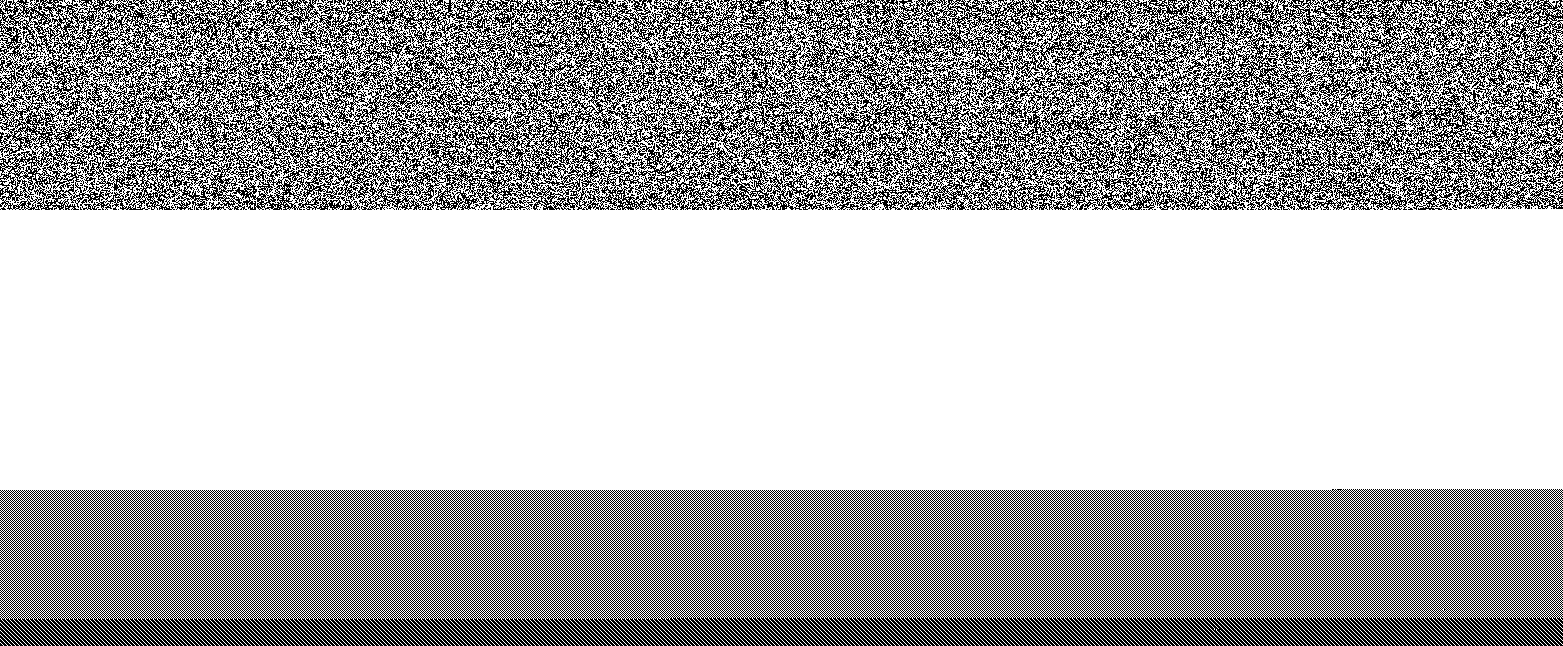

In [26]:
GPU_convolution = native_recurse_pooling( green, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

### blue

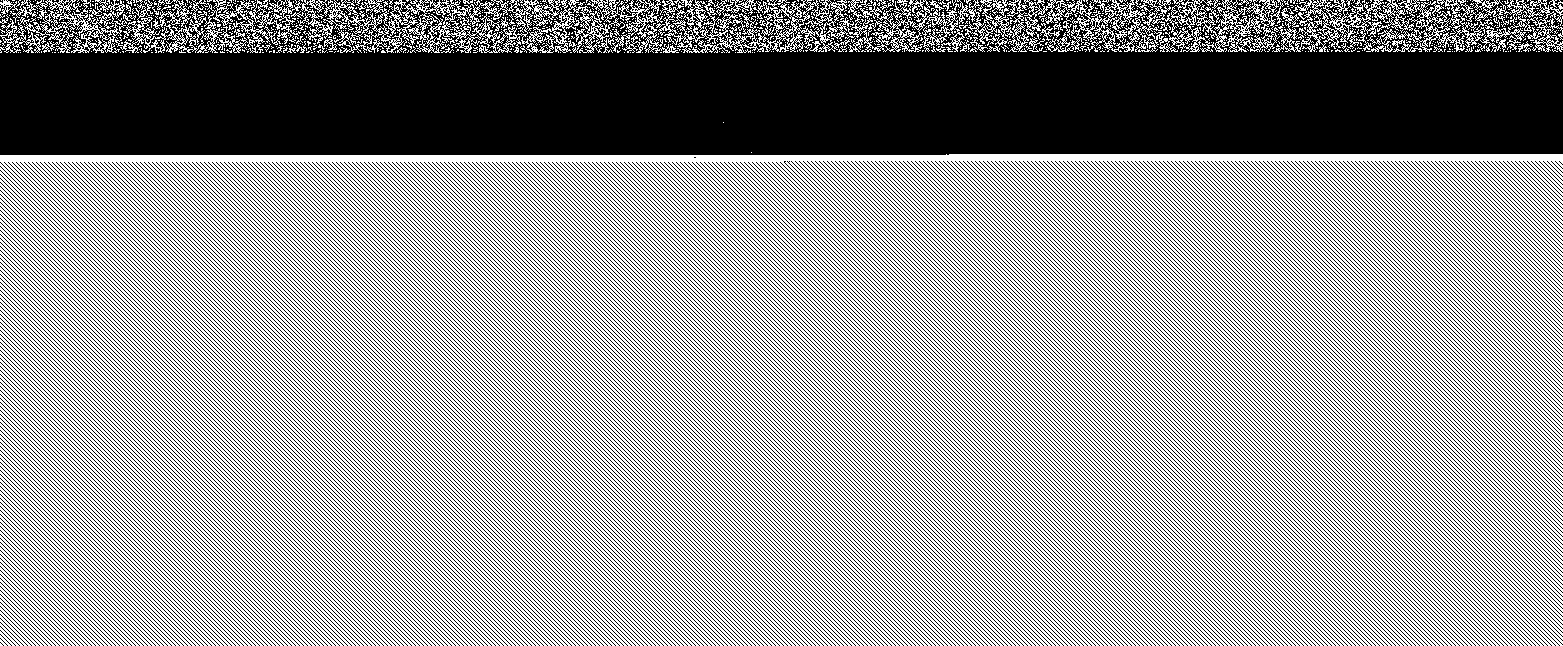

In [27]:
GPU_convolution = native_recurse_pooling( blue, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

### red

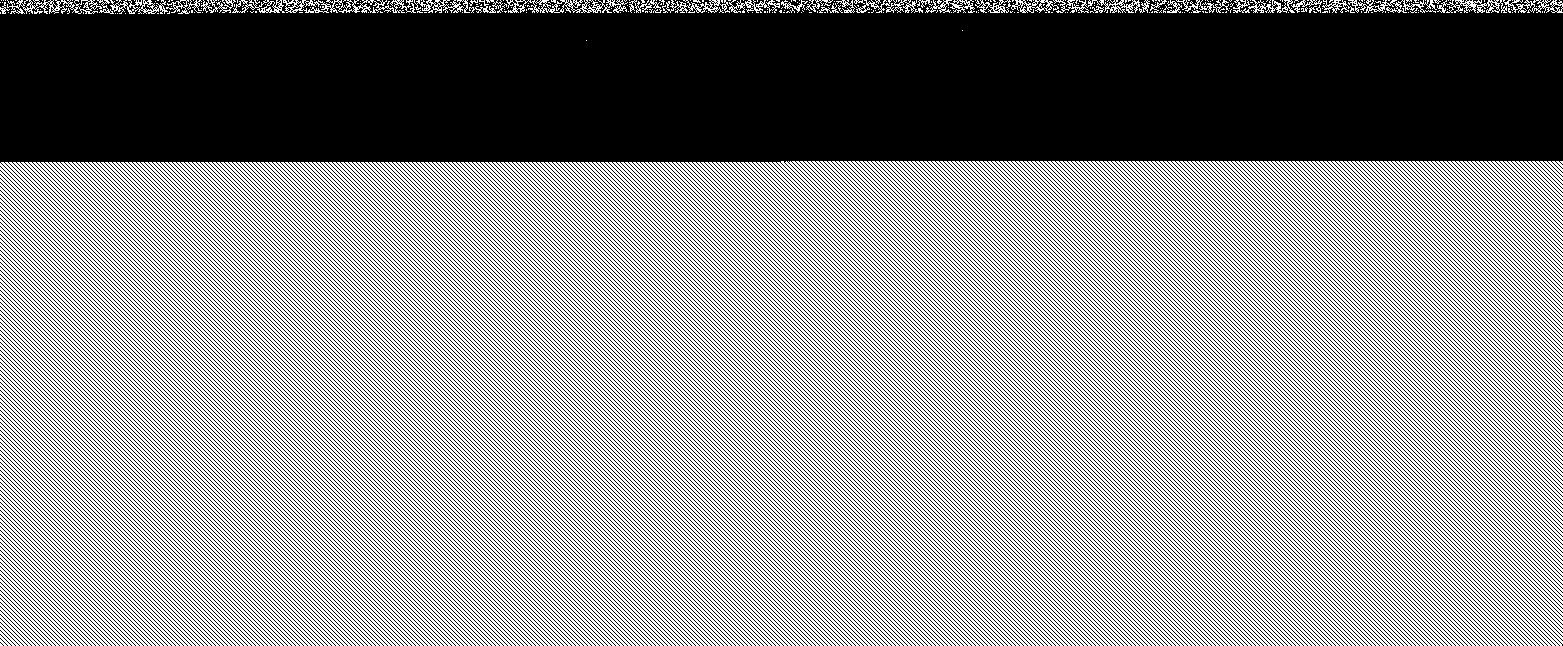

In [28]:
GPU_convolution = native_recurse_pooling( red, width, recurse_cnt, use_max, gpu_function_ptr )
display_channel ( GPU_convolution, width-recurse_cnt )

# NEXT - Comparing GPU vs C++ vs Python

http://localhost:8888/notebooks/6_GPU_v_C%2B%2B_Python.ipynb